In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Reading the data
TicketData=pd.read_csv('supportTicketData.csv')

# Printing number of rows and columns
print(TicketData.shape)

# Printing sample rows
TicketData.head(10)

(19796, 2)


,body,urgency
0,connection issues with assigned address hi fac...,P1
1,cannot access hi cannot access fallowing link ...,P2
2,re address shown valid dear colleagues remarke...,P1
3,sent tuesday critical alert following alert oc...,P2
4,code spelling mistake hello should discover fo...,P2
5,annual leave hello sent last week about previo...,P2
6,report working hello dear last two weeks have ...,P2
7,more access lost access please reset password ...,P1
8,open credentials required please assist instal...,P1
9,dear please ask our supplier for price quotati...,P2


urgency
P1    6748
P2    5528
P3    7520
dtype: int64


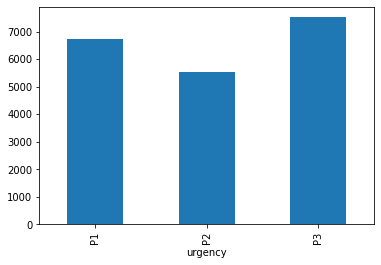

In [2]:
# Number of unique values for urgency column
# You can see there are 3 ticket types
print(TicketData.groupby('urgency').size())

# Plotting the bar chart
%matplotlib inline
TicketData.groupby('urgency').size().plot(kind='bar');

In [3]:
# Count vectorization of text
from sklearn.feature_extraction.text import CountVectorizer

# Ticket Data
corpus = TicketData['body'].values

# Creating the vectorizer
vectorizer = CountVectorizer(stop_words='english')

# Converting the text to numeric data
X = vectorizer.fit_transform(corpus)

#print(vectorizer.get_feature_names())

# Preparing Data frame For machine learning
# Priority column acts as a target variable and other columns as predictors
CountVectorizedData=pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
CountVectorizedData['Priority']=TicketData['urgency']
print(CountVectorizedData.shape)
CountVectorizedData.head()

(19796, 9100)


,ab,abandon,abandoned,abc,abeam,abilities,ability,able,abnormal,abnormally,...,zig,zip,zipped,zipper,zipping,zone,zones,zoom,zooming,Priority
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,P1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,P2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,P1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,P2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,P2


Word2Vec conversion:
Now we will use the Word2Vec representation of words to convert the above document term matrix to a smaller matrix, where the columns are the sum of the vectors for each word present in the document.

We will Use the Pre-trained word2Vec model from google, It contains word vectors for a vocabulary of 3 million words.
Trained on around 100 billion words from the google news dataset.

In [4]:
import gensim
#Loading the word vectors from Google trained word2Vec model
GoogleModel = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary=True,)

In [5]:
# Each word is a vector of 300 numbers
GoogleModel['hello'].shape

(300,)

In [6]:
GoogleModel['hello']

array([-0.05419922,  0.01708984, -0.00527954,  0.33203125, -0.25      ,
       -0.01397705, -0.15039062, -0.265625  ,  0.01647949,  0.3828125 ,
       -0.03295898, -0.09716797, -0.16308594, -0.04443359,  0.00946045,
        0.18457031,  0.03637695,  0.16601562,  0.36328125, -0.25585938,
        0.375     ,  0.171875  ,  0.21386719, -0.19921875,  0.13085938,
       -0.07275391, -0.02819824,  0.11621094,  0.15332031,  0.09082031,
        0.06787109, -0.0300293 , -0.16894531, -0.20800781, -0.03710938,
       -0.22753906,  0.26367188,  0.012146  ,  0.18359375,  0.31054688,
       -0.10791016, -0.19140625,  0.21582031,  0.13183594, -0.03515625,
        0.18554688, -0.30859375,  0.04785156, -0.10986328,  0.14355469,
       -0.43554688, -0.0378418 ,  0.10839844,  0.140625  , -0.10595703,
        0.26171875, -0.17089844,  0.39453125,  0.12597656, -0.27734375,
       -0.28125   ,  0.14746094, -0.20996094,  0.02355957,  0.18457031,
        0.00445557, -0.27929688, -0.03637695, -0.29296875,  0.19

In [7]:
# Finding similar words
# The most_similar() function finds the cosine similarity of the given word with 
# other words using the word2Vec representations of each word
GoogleModel.most_similar('king', topn=5)

[('kings', 0.7138045430183411),
 ('queen', 0.6510956883430481),
 ('monarch', 0.6413194537162781),
 ('crown_prince', 0.6204220056533813),
 ('prince', 0.6159993410110474)]

In [8]:
# Checking if a word is present in the Model Vocabulary
'Hello' in GoogleModel.key_to_index.keys()

True

In [9]:
# Creating the list of words which are present in the Document term matrix
WordsVocab=CountVectorizedData.columns[:-1]

# Printing sample words
WordsVocab[0:10]

Index(['ab', 'abandon', 'abandoned', 'abc', 'abeam', 'abilities', 'ability',
       'able', 'abnormal', 'abnormally'],
      dtype='object')

## Converting every sentence to a numeric vector

For each word in a sentence, we extract the numeric form of the word and then simply add all the numeric forms for that sentence to represent the sentence.

In [10]:
# Defining a function which takes text input and returns one vector for each sentence
def FunctionText2Vec(inpTextData):
    # Converting the text to numeric data
    X = vectorizer.transform(inpTextData)
    CountVecData=pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
    
    # Creating empty dataframe to hold sentences
    W2Vec_Data=pd.DataFrame()
    
    # Looping through each row for the data
    for i in range(CountVecData.shape[0]):

        # initiating a sentence with all zeros
        Sentence = np.zeros(300)

        # Looping thru each word in the sentence and if its present in 
        # the Word2Vec model then storing its vector
        for word in WordsVocab[CountVecData.iloc[i,:] &gt;= 1]:
            #print(word)
            if word in GoogleModel.key_to_index.keys():    
                Sentence=Sentence+GoogleModel[word]
        # Appending the sentence to the dataframe
        W2Vec_Data=W2Vec_Data.append(pd.DataFrame([Sentence]))
    return(W2Vec_Data)

SyntaxError: expected ':' (1424483925.py, line 18)

In [ ]:
sum=0
for i in range(len(CountVectorizedData.iloc[2,:])):
    if CountVectorizedData.iloc[2,:][i]==1:
        print(list(CountVectorizedData.iloc[2,:]).index(CountVectorizedData.iloc[2,:][i],i))
        sum += 1
print(sum)

28
155
386
529
794
1070
1231
1429
1714
1740
1997
2242
2683
2753
3062
3457
3516
3586
3695
3742
3830
4047
4092
4332
4335
5001
5468
5473
5475
5651
6040
6062
6424
6673
6689
6834
6922
6923
7168
8201
8277
8333
8360
8427
8464
8518
8767
9049
9050
9074
50


In [11]:
# Calling the function to convert all the text data to Word2Vec Vectors
W2Vec_Data=FunctionText2Vec(TicketData['body'])
 
# Checking the new representation for sentences
W2Vec_Data.shape

NameError: name 'FunctionText2Vec' is not defined

In [12]:
	
# Comparing the above with the document term matrix
CountVectorizedData.shape

(19796, 9100)

In [ ]:

# Adding the target variable
W2Vec_Data.reset_index(inplace=True, drop=True)
W2Vec_Data['Priority']=CountVectorizedData['Priority']
 
# Assigning to DataForML variable
DataForML=W2Vec_Data
DataForML.head()

In [ ]:
# Separate Target Variable and Predictor Variables
TargetVariable=DataForML.columns[-1]
Predictors=DataForML.columns[:-1]

X=DataForML[Predictors].values
y=DataForML[TargetVariable].values

# Split the data into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=428)

# Sanity check for the sampled data
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Choose either standardization or Normalization
# On this data Min Max Normalization is used because we need to fit Naive Bayes

# Choose between standardization and MinMAx normalization
#PredictorScaler=StandardScaler()
PredictorScaler=MinMaxScaler()

# Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X)

# Generating the standardized values of X
X=PredictorScalerFit.transform(X)

# Split the data into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=428)

# Sanity check for the sampled data
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

In [ ]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB, MultinomialNB

# GaussianNB is used in Binomial Classification
# MultinomialNB is used in multi-class classification
#clf = GaussianNB()
clf = MultinomialNB()

# Printing all the parameters of Naive Bayes
print(clf)

NB=clf.fit(X_train,y_train)
prediction=NB.predict(X_test)

# Measuring accuracy on Testing Data
from sklearn import metrics
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(y_test, prediction))

# Printing the Overall Accuracy of the model
F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
print('Accuracy of the model on Testing Sample Data:', round(F1_Score,2))

# Importing cross validation function from sklearn
from sklearn.model_selection import cross_val_score

# Running 10-Fold Cross validation on a given algorithm
# Passing full data X and y because the K-fold will split the data and automatically choose train/test
Accuracy_Values=cross_val_score(NB, X , y, cv=5, scoring='f1_weighted')
print('\nAccuracy values for 5-fold Cross Validation:\n',Accuracy_Values)
print('\nFinal Average Accuracy of the model:', round(Accuracy_Values.mean(),2))